# UMAP Plot

Use the bodies of text that describes a feed to create a UMAP Plot.

## Load Features

Load all information for all feeds or posts in the database that have features.

Store the results in the *feeds* or *posts* dicts.

In [13]:
import sqlite3
import umap, umap.plot
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import scipy

# stop words lists
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# stores the posts in a dict
feeds = dict()

print('Loading feed info...')

# connect to the db
conn = sqlite3.connect('../web/feeds.db')
c = conn.cursor()
    
# select only the feeds for which the body of text 
# has already been generated
c.execute('SELECT url, text, title, description FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL;')
for entry in c.fetchall():
    feeds[entry[0]] = {
        'text': entry[1],
        'title': entry[2],
        'description': entry[3]
    }        

print('Loaded info for ' + str(len(feeds)) + ' feeds')

Loading feed info...
Loaded info for 37257 feeds


In [3]:
lengths = [len(f['text'].split()) for f in feeds.values()]

print('Minimum length of text:', min(lengths))
print('Average length of text:', np.average(lengths))
print('Maximum length of text:', max(lengths))


Minimum length of text: 101
Average length of text: 463.4380921705988
Maximum length of text: 500


## Vectorize Documents

### Custom Pre-processor

Define custom pre-processor for the vectorizers.

In [3]:
from english_words import english_words_lower_set

# define a function that will be used to pre-process data before being vectorized
def custom_preprocessor(text):

    # convert to lower case
    text = text.lower()

    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # lemmatize text using WordNet
    lemmatizer = WordNetLemmatizer()

    lemmatized_words = list()
    for word in word_tokenize(text):

        # determine the part-of-speech tag for the word
        pos = nltk.pos_tag([word])[0][1][0] # only the first letter matters (hence the 0 at the end)

        # default to noun if the tag does not fall into the categories accepted by lemmatize()
        if pos != 'V' and pos != 'N' and pos != 'R' and pos != 'J':
            pos = 'N'
        if pos == 'J':
            pos = 'A'
        pos = pos.lower()

        # lemmatize the word and add to list
        lemma = lemmatizer.lemmatize(word, pos)
        if lemma in english_words_lower_set:
            lemmatized_words.append(lemma)

    # join the lemmatized words together
    text = ' '.join(lemmatized_words)   

    return text 

### Binary Matrix

Generate a doc-word matrix with binary counts for words.

In [4]:
corpus = list(f['text'] for f in feeds.values())

# generate a stop words list by joining multiple predefined lists
stopwords_list = list(set(sw_nltk) | set(sw_spacy) | set(STOPWORDS) | set(ENGLISH_STOP_WORDS))

# custom stop words (was given warning that these are not included in stop_words)
stopwords_list.extend(['doe', 'ha', 'le', 'need', 'sha', 'wa', 'wo', 'far', 'regard', 'use'])

vectorizer = CountVectorizer(max_features=20000, preprocessor=custom_preprocessor, binary=True, stop_words=stopwords_list)
doc_word = vectorizer.fit_transform(corpus)

# get the words (column labels)
words = vectorizer.get_feature_names()

# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (posts): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

# save the binary vectorized data
scipy.sparse.save_npz('binary_matrix', doc_word)
np.save('binary_words', np.asarray(words))

Shape of doc-word matrix:  (37257, 20000)
Number of documents (posts):  37257
Number of words (features):  20000


### TF-IDF Matrix

Generate a doc-word matrix with TF-IDF values for words.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer = TfidfVectorizer(max_features=20000, preprocessor=custom_preprocessor, stop_words=stopwords_list)
doc_word_tfidf = tfIdfVectorizer.fit_transform(corpus)

# get the words (column labels)
words_tfidf = tfIdfVectorizer.get_feature_names()

# save the binary vectorized data
scipy.sparse.save_npz('tfidf_matrix', doc_word_tfidf)
np.save('tfidf_words', np.asarray(words_tfidf))

### Load Matrices

Load the vectorized data from files.

In [10]:
# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

# binary matrix
doc_word = scipy.sparse.load_npz('binary_matrix.npz')
words =  np.load('binary_words.npy')

# tfidf matrix
doc_word_tfidf = scipy.sparse.load_npz('tfidf_matrix.npz')
words_tfidf = np.load('tfidf_words.npy')

## CorEx Topic Modelling

Use the CorEx library to infer topics from the bodies of text of the feeds.

### Train the Model

In [4]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=20, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

### Plot the Distribution of TCs For Each Topic

Use the plot to select an appropriate number of topics. Keep adding topics until additional ones do not significantly contribute to the overall TC.

Total Correlation of the model: 20.844898461396063


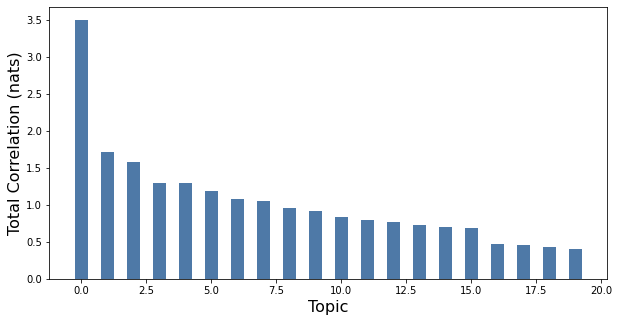

In [5]:
print('Total Correlation of the model:', str(topic_model.tc))

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

### Display All Topics Generated

In [6]:
topics = topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: recipe, delicious, ingredient, food, dish, meal, sauce, creamy, chicken, dessert, chocolate, sweet
1: travel, city, trip, visit, park, island, beach, south, north, mountain, town, hotel
2: music, song, album, debut, john, film, story, star, tip, author, title, director
3: law, court, state, federal, legal, policy, attorney, police, president, issue, lawyer, act
4: business, market, financial, strategy, service, investor, employee, money, invest, growth, income, revenue
5: company, technology, data, industry, software, digital, platform, solution, product, tech, web, design
6: health, body, diet, healthy, symptom, skin, cause, surgery, care, weight, muscle, chronic
7: help, important, improve, increase, process, benefit, provide, common, tool, impact, learn, practice
8: thing, like, think, time, feel, want, know, lot, way, little, good, try
9: patient, child, life, therapy, mental, parent, pain, anxiety, people, doctor, woman, cancer
10: god, church, jesus, christian, christ, faith, 

### Get the Topic and Top Feeds for Random Word

In [17]:
# Get the index of the word in the vocabulary
word_index = list(words).index('doctor')

# Get the topic associated with that word
word_topic = topic_model.clusters[word_index]

# Get top 10 documents for the topic
top_docs = topic_model.get_top_docs(topic=word_topic, n_docs=15, sort_by='log_prob')

print('Topic', word_topic)
for doc in top_docs:
    print(doc)

Topic 2
('https://www.brideeveryday.com/feed', 0.0)
('https://georgerook51.wordpress.com/feed/', 0.0)
('https://www.healthywomen.org/rss.xml?x=1', 0.0)
('https://www.soundhealthandlastingwealth.com/feed/', 0.0)
('https://www.healthista.com/feed/', 0.0)
('https://nutritionfacts.org/feed/', 0.0)
('https://www.mindfulnessfirst.org/blog?format=rss', 0.0)
('https://thesaffronstoryteller.com/feed/', 0.0)
('https://www.alittlenutrition.com/feed/', 0.0)
('https://thejointblog.com/feed/', 0.0)
('https://www.iawaketechnologies.com/feed/', 0.0)
('https://mysites.therapysites.com/0039423/blog/rss.xml', 0.0)
('https://howtherapyworks.com/feed/', 0.0)
('https://drgeraldstein.wordpress.com/feed/', 0.0)
('https://www.littlerockfamily.com/rss', 0.0)


### Reduce Using PCA

In [42]:
from sklearn.decomposition import PCA
import math

pca = PCA(n_components=3)
rgb = pca.fit_transform(topic_model.p_y_given_x)

rgb = rgb - np.min(rgb, axis=0)
rgb = rgb / np.max(rgb, axis=0)
rgb = rgb * 255

hex = []
for rgb_color in rgb:
    
    r = int(rgb_color[0])
    g = int(rgb_color[1])
    b = int(rgb_color[2])

    hex.append('#%02x%02x%02x' % (r, g, b))

### Anchored CorEx

Use anchor words to help CorEx find topics.

Total Correlation of the model: 55.473340881053694


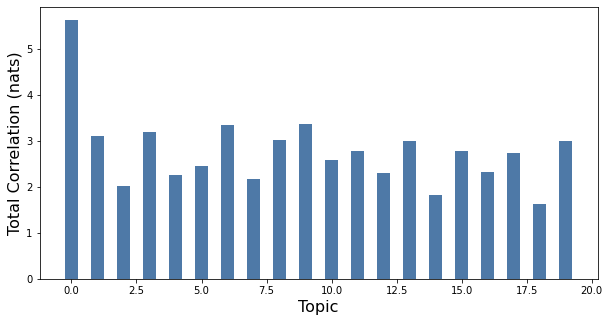

0: recipe, ingredient, meal, food, dish, delicious, eat, sauce, chicken, chocolate, dessert, creamy
1: travel, visit, trip, adventure, city, beach, road, island, hotel, park, itinerary, mountain
2: music, song, album, band, musician, lyric, vocal, concert, single, dance, guitar, listen
3: director, film, actor, easy, announce, tip, february, simple, president, way, post, thursday
4: book, author, library, write, novel, fiction, literary, read, bestselling, chapter, kindle, copy
5: law, court, legal, lawyer, attorney, state, federal, supreme, police, case, act, claim
6: business, company, investor, entrepreneur, brand, industry, market, employee, product, sale, revenue, startup
7: money, stock, finance, investor, financial, invest, save, income, bank, cash, fund, tax
8: company, technology, digital, software, tech, platform, device, mobile, virtual, smart, create, machine
9: health, patient, doctor, symptom, surgery, care, medicine, cause, chronic, pain, cancer, condition
10: health, bo

In [15]:
# Define anchor words
anchors = [
    ['recipe', 'ingredient', 'food', 'meal', 'dish'],
    ['travel', 'trip', 'visit'],
    ['music', 'song', 'album'],
    ['film', 'actor', 'director'],
    ['book', 'author', 'library'],
    ['law', 'legal', 'court', 'attorney', 'lawyer'],
    ['business', 'company', 'entrepreneur', 'investor', 'brand'],
    ['finance', 'stock', 'money', 'investor'],
    ['company', 'technology', 'software', 'digital', 'tech'],
    ['health', 'doctor', 'symptom', 'patient', 'surgery'],
    ['health', 'fit', 'body', 'weight', 'muscle'],
    ['health', 'mental', 'psychology', 'anxiety', 'doctor', 'therapy'],
    ['god', 'church', 'jesus', 'christian', 'faith', 'bible'],
    ['holiday', 'christmas', 'gift', 'valentine'],
    ['knit', 'sew', 'craft', 'pattern', 'fabric'],
    ['sport', 'game', 'league', 'team', 'champion', 'athlete'],
    ['style', 'fashion', 'wear', 'wardrobe'],
    ['student', 'class', 'school', 'college', 'classroom'],
    ['science', 'scientist', 'professor', 'journal'],
    ['climate', 'emission', 'vehicle', 'solar', 'carbon'],
]

anchored_topic_model = ct.Corex(n_hidden=20, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchors, anchor_strength=6)

print('Total Correlation of the model:', str(anchored_topic_model.tc))

plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

topics = anchored_topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))


# Save results
np.save('anchored_labels', anchored_topic_model.labels)
np.save('anchored_word_clusters', np.asarray(anchored_topic_model.clusters))

### Display Topic Assignments

Show topics assigned to a feed given its url

In [6]:
feed_url_list = [
    'http://feeds.feedburner.com/tennisx'
]

for url in feed_url_list:
    
    # Get the index of the feed with the given url
    index = list(feeds.keys()).index(url)

    print(feeds[list(feeds.keys())[index]]['title'])
    print(feeds[list(feeds.keys())[index]]['description'])

    # Print topics that the feed belongs to
    print(np.where(anchored_topic_model.labels[index])[0])
    print()

The Dysfunctional Tennis Blog
A healthy dose of pro tennis blogging.
[ 3 15 17]



### Assign a Topic to Each Feed

For each feed, assign it the topic such that the feed has the highest probability of belonging to that topic.

In [ ]:
# Make a hard assignment of one topic per document
hard_labels = np.zeros(doc_word.shape[0])

for i in range(hard_labels.shape[0]):
    hard_labels[i] = np.argmax(topic_model.p_y_given_x[i])

## UMAP Plots

### Topic Probabilities

Create an interactive UMAP plot based on the probabilities that each feed belongs to a topic. 

In [ ]:
# fit UMAP model
mapper = umap.UMAP().fit(topic_model.p_y_given_x)

In [ ]:
# data to be displayed when hovering over a point in the interactive plot
hover_data = pd.DataFrame({
    'title': [f['title'] for f in list(feeds.values())],
    'description': [f['description'] for f in list(feeds.values())],
    'label': hard_labels
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=hard_labels, hover_data=hover_data, point_size=4)
umap.plot.show(p)

### TF-IDF

Use TF-IDF values without topic modelling in the UMAP plot.

In [11]:
# fit umap with tf-idf doc word matrix (without topic modelling)
tfidf_raw_mapper = umap.UMAP().fit(doc_word_tfidf)

In [15]:


hover_data = pd.DataFrame({
    'title': [f['title'] for f in feeds.values()],
    'description': [f['description'] for f in feeds.values()],
})

labels = [f['title'] for f in feeds.values()]

umap.plot.output_notebook()
p = umap.plot.interactive(tfidf_raw_mapper, hover_data=hover_data, point_size=4)
umap.plot.show(p)

Loading BokehJS ...

# Make Recommendations

Build a user profile by averaging the feature vectors of the liked feeds and finding the feeds that are closest to the user's feature vector

### Liked Feeds

Hardcode a list of the user's liked feeds

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

# Feeds liked by the user
liked_urls = [
    'https://www.gousto.co.uk/blog/feed',
    'https://bakingqueen74.co.uk/feed/',
    'https://emmaeatsandexplores.com/feed/',
    'https://larderlove.com/feed/',
    'https://www.davidlebovitz.com/feed/',
    'https://homegrownhappiness.co.nz/feed/',
    'http://foodwishes.blogspot.com/feeds/posts/default',
    'https://www.chowhound.com/food-news/feed/',
    'http://feeds.feedburner.com/notjustbaked',
    'https://www.japanesecooking101.com/feed/',
    'http://thetennisfoodie.com/blog/feed/',
    'http://www.tennisviewmag.com/rss.xml',
    'https://feed.podbean.com/essentialtennis/feed.xml',
    'http://feeds.feedburner.com/tennisx',
    'http://feeds.feedburner.com/tennis-australia',
    'https://rafaelnadalfans.com/feed/',
    'http://feeds.bbci.co.uk/sport/tennis/rss.xml',
    'https://www.espn.com/espn/rss/tennis/news?null',
    'https://ftw.usatoday.com/category/tennis/feed',
    'https://greatcurryrecipes.net/feed/',
    'https://www.thepetitecook.com/feed/',
    'https://www.myfussyeater.com/feed/',
    'https://www.easycheesyvegetarian.com/feed/',
    'https://wallflowerkitchen.com/feed/',
    'https://recipesfromapantry.com/feed/',
    'https://www.tamingtwins.com/feed/',
    'https://www.giverecipe.com/feed/',
    'https://tinandthyme.uk/feed/'
]

### CorEx Based

Use topic assignments as features. 
Get the topics associated with the words selected by the user and use them when building the user profile.

In [12]:
# Construct user profile in the feature space
user_profile = np.zeros(20)

# Average feature vectors of liked feeds
for feed_url in liked_urls:
    feed_index = list(feeds.keys()).index(feed_url)
    user_profile += anchored_topic_model.labels[feed_index]
    
# Hardoded list of words selected by the user
user_words = ['tennis', 'food', 'recipe']

# Get the topic associated with each of the words
for word in user_words:
    
    # Get the index of the word in the vocabulary
    word_index = list(words).index(word)

    # Use the topic associated with the word
    user_profile += anchored_topic_model.clusters[word_index]

user_profile /= (len(liked_urls) + len(user_words))

# Calculate the distance between user profile and each feed
distances_matrix = euclidean_distances([user_profile], anchored_topic_model.labels)

# Get first 10 closest feeds
closest_feeds_index = np.argsort(distances_matrix[0])[:10]

for index in closest_feeds_index:
    print(feeds[list(feeds.keys())[index]]['title'])
    print(feeds[list(feeds.keys())[index]]['description'])
    print()

WCCO | CBS Minnesota
News, Sports, Weather, Traffic, and the Best of Minnesota, and the Twin Cities of Minneapolis-St. Paul.

Perfectly Provence
Provence lifestyle magazine. Your South of France resource for food, wine, travel, real estate and expat living.

Blog feed - Willa Gebbie  | Watercolour Food, Portrait and  Lifestyle Illustration
<p>Blog, news and goings-on by fashion and beauty illustrator,&nbsp;Willa Gebbie</p>

The Growler B.C. | B.C.'s Craft Beer Guide
B.C.'S CRAFT BEER AND CIDER GUIDE

Michigan Runner Girl
Mind Over Miles

Blog • Michigan Runner Girl
Mind Over Miles

MGH DiabetesViews
Empowering you to manage your Diabetes

Mile High Mamas
Denver parenting, with altitude

Northern Friends Caravan and Camping Club
The Friendly Fun Club

Forbes - Real Estate
Forbes - Real Estate



### TF-IDF Based

Use the TF-IDF representation of feeds as features

In [10]:
# Load the doc-word matrix with tf-idf values
doc_word_tfidf = scipy.sparse.load_npz('tfidf_matrix.npz')

# Construct user profile in the TF-IDF feature space
user_profile = np.zeros((20000,))

# Average the feature vectors of the feeds
for feed_url in liked_urls:
    feed_index = list(feeds.keys()).index(feed_url)
    user_profile += np.array(doc_word_tfidf[feed_index].todense()).ravel()

user_profile /= len(liked_urls)

# Calculate the distance between user profile and each feed
distances_matrix = euclidean_distances([user_profile], doc_word_tfidf)

# Get first 10 closest feeds
closest_feeds_index = np.argsort(distances_matrix[0])[:100]
np.random.shuffle(closest_feeds_index)

for index in closest_feeds_index[:10]:
    print(feeds[list(feeds.keys())[index]]['title'])
    print(feeds[list(feeds.keys())[index]]['description'])
    print()

Veg Vegan Meat
Indian and Global Recipes

Food For Fitness
We Make Losing Weight Easy

The Home Cook's Kitchen
Bringing People Together With Food

Sportsnet.ca
Sports News: World and National Sports Headlines, Score Updates, Highlights, Stats &amp; Results

F and B Recipes
Authentic Food Recipes

The US Open 2020 - Grand Slam Tennis - Official Site by IBM
The US Open 2020 - Grand Slam Tennis.  The US Open is held annually at the USTA Billie Jean King National Tennis Center.

Traditional Home Baking
Easy Baking Recipes for the Home Cook

BakingQueen74
Baking and Slow Cooking Recipes

RSS
Tennis View Magazine is committed to delivering relevant articles that offer a fresh approach, perspective, and visual appeal.

Taming Twins
Recipes and Meal Planning for Busy Families

